<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/Trabaho1_MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho de Feature Enginearing
Disciplina: Algoritmos Baseados em Dados para Problemas de Ciência e Engenharia.

Aluno: Carlos A M Monteiro

# 1. Conjunto de Dados

## 1.1 Importa os dados de Plano de Saúde

In [ ]:
import kagglehub
import pandas as pd
import numpy as np

# Download latest version
path = kagglehub.dataset_download("steve1215rogg/student-lifestyle-dataset")

print("Path to dataset files:", path)

dados = pd.read_csv(path + "/student_lifestyle_dataset.csv")
dados.head()

Using Colab cache for faster access to the 'student-lifestyle-dataset' dataset.
Path to dataset files: /kaggle/input/student-lifestyle-dataset


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


In [ ]:
dados['Stress_Level'].unique()

array(['Moderate', 'Low', 'High'], dtype=object)

In [ ]:
dados.drop(columns=['Student_ID'], inplace=True)
dados['Stress_Level'] = dados['Stress_Level'].map({'Moderate': 1, 'Low': 0, 'High': 2})
dados

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,6.9,3.8,8.7,2.8,1.8,2.99,1
1,5.3,3.5,8.0,4.2,3.0,2.75,0
2,5.1,3.9,9.2,1.2,4.6,2.67,0
3,6.5,2.1,7.2,1.7,6.5,2.88,1
4,8.1,0.6,6.5,2.2,6.6,3.51,2
...,...,...,...,...,...,...,...
1995,6.5,0.2,7.4,2.1,7.8,3.32,1
1996,6.3,2.8,8.8,1.5,4.6,2.65,1
1997,6.2,0.0,6.2,0.8,10.8,3.14,1
1998,8.1,0.7,7.6,3.5,4.1,3.04,2


## 1.1. Gera dados

In [156]:
import torch as tc
import pandas as pd
import numpy as np

num_amostras = 5000


dados = pd.DataFrame()
dados['x1'] = 6 + tc.randn(num_amostras)
dados['x2'] = [1.5*np.sin(0.002*idx) + n for idx, n in enumerate(dados['x1'])]
dados['x3'] = [0.001*idx+n for idx, n in enumerate(dados['x1'])]
dados['x4'] = [abs(n*np.sin(0.0025*idx))  for idx, n in enumerate(dados['x1'])]
dados['x5'] = [n + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]
dados['x6'] = [0.0003*idx + 0.8*np.sin(0.0008*idx) + n + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]
dados['x7'] = tc.rand(num_amostras)
dados['x8'] = [-np.log(n) for idx, n in enumerate(dados['x7'])]
dados['y'] = [10 + n*np.sin(0.0025*idx) + dados['x7'][idx]*np.sin(0.001*idx) + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]

dados

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,4.418979,4.418979,4.418979,0.000000,3.790175,3.851154,0.841437,0.172644,10.006632
1,4.806399,4.809399,4.807399,0.012016,5.424897,4.890461,0.498349,0.696455,9.938585
2,5.969800,5.975800,5.971800,0.029849,6.736295,5.470011,0.596714,0.516318,9.919348
3,5.926910,5.935910,5.929910,0.044451,5.585835,4.524609,0.429700,0.844668,9.617414
4,6.970652,6.982651,6.974652,0.069705,7.504256,6.702637,0.263222,1.334756,9.215570
...,...,...,...,...,...,...,...,...,...
4995,6.487164,5.683759,11.482164,0.511116,6.789837,7.482020,0.262661,1.336890,8.050487
4996,6.294572,5.488636,11.290572,0.480253,6.525889,6.712077,0.969564,0.030908,7.706117
4997,5.301585,4.493119,10.298585,0.391275,5.146483,8.045224,0.409723,0.892275,8.534620
4998,6.342853,5.531862,11.340853,0.452309,5.727391,9.408196,0.161502,1.823239,10.351434


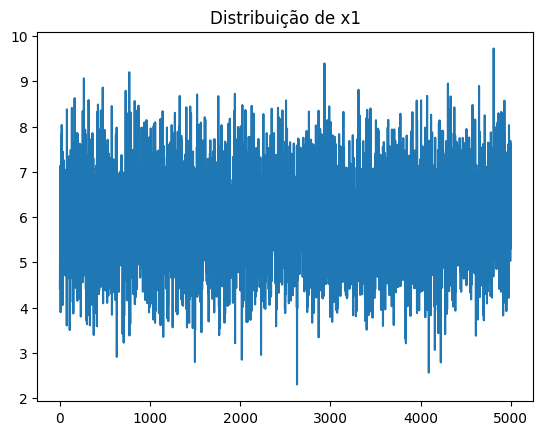

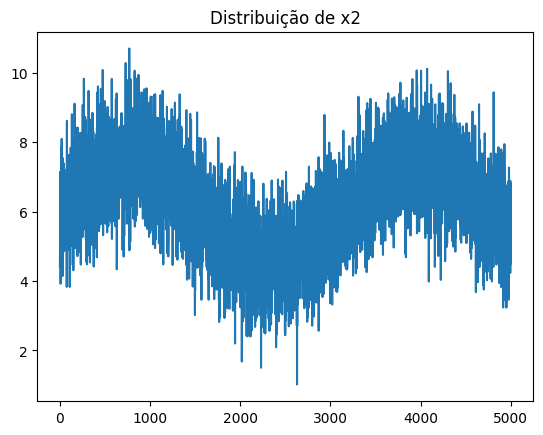

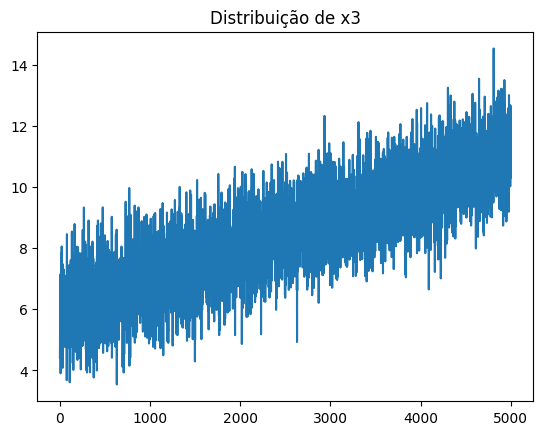

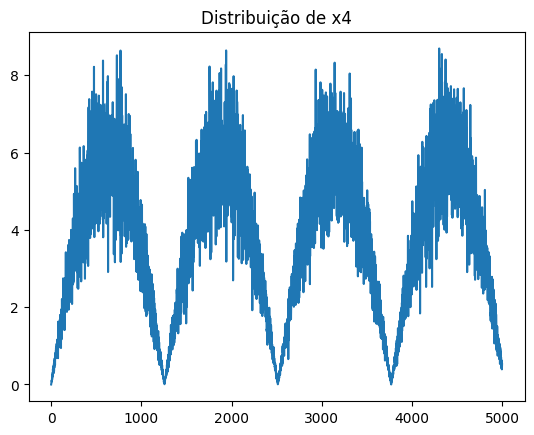

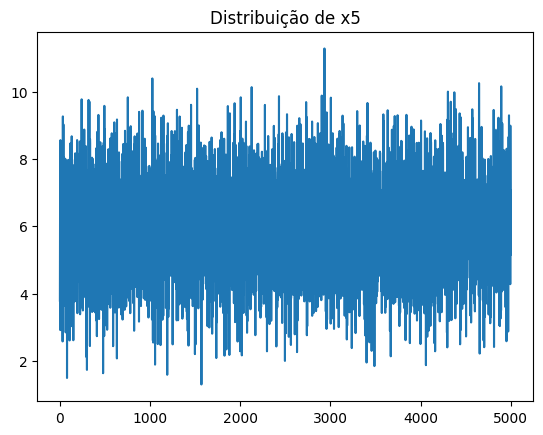

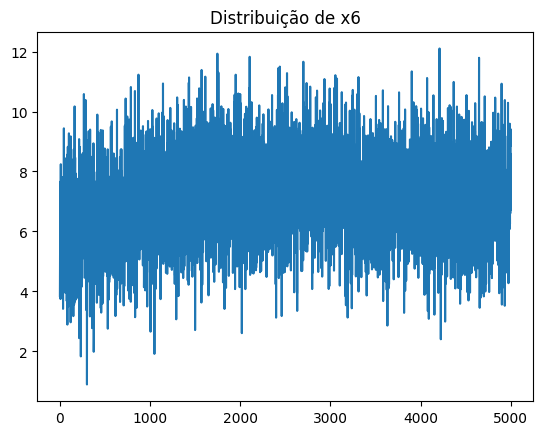

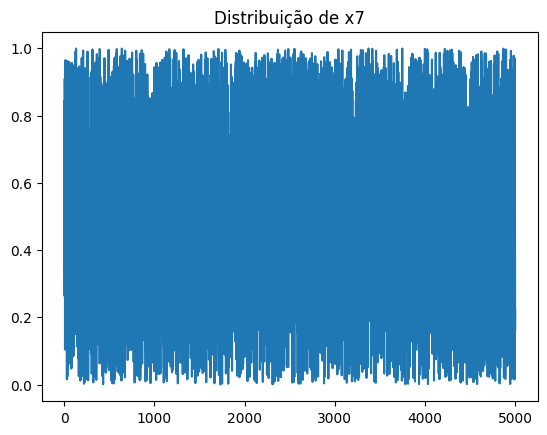

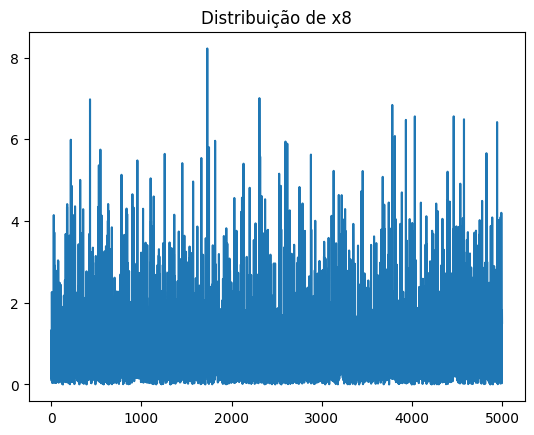

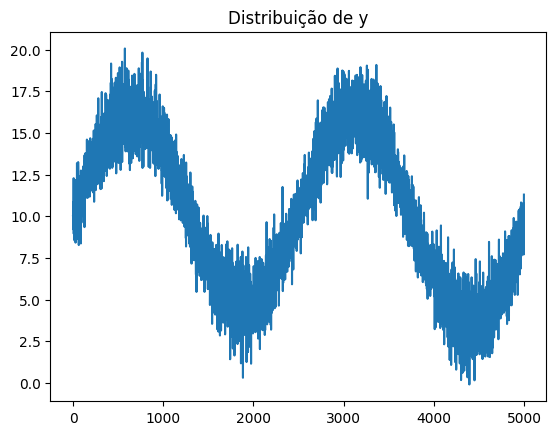

In [157]:
from matplotlib import pyplot as plt

for d in dados.columns:
  plt.figure()
  plt.title(f'Distribuição de {d}')
  dados[d].plot()
  plt.show()

## 1.2 Gráficos dos dados em relação a saída

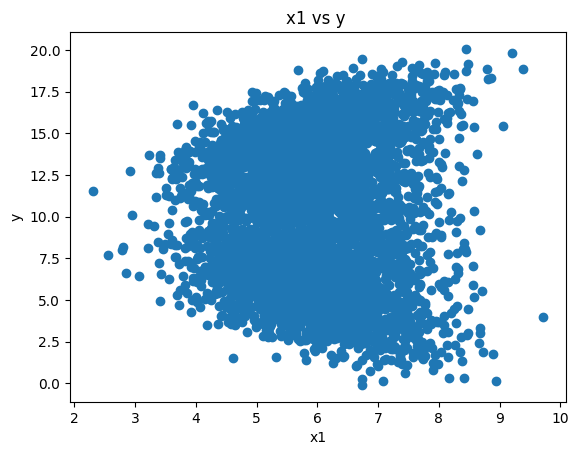

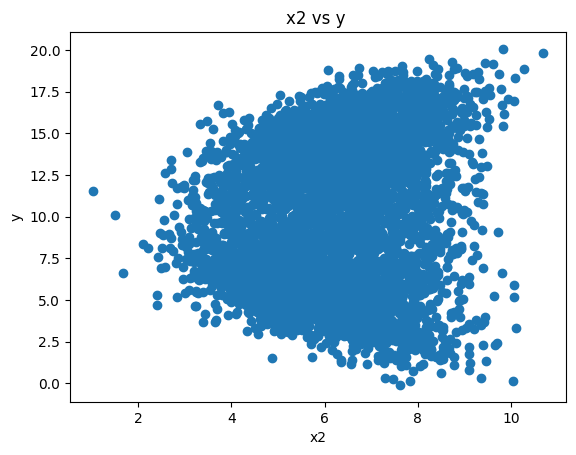

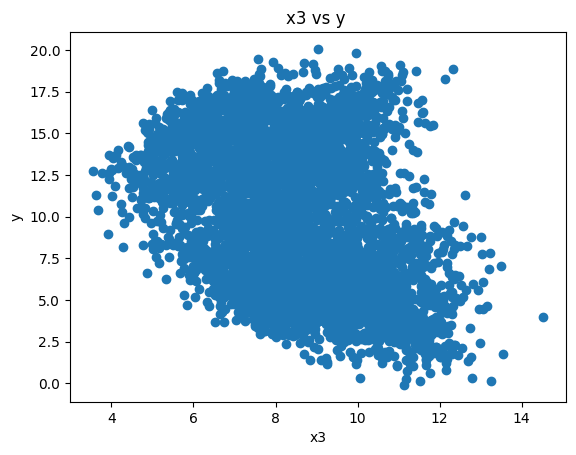

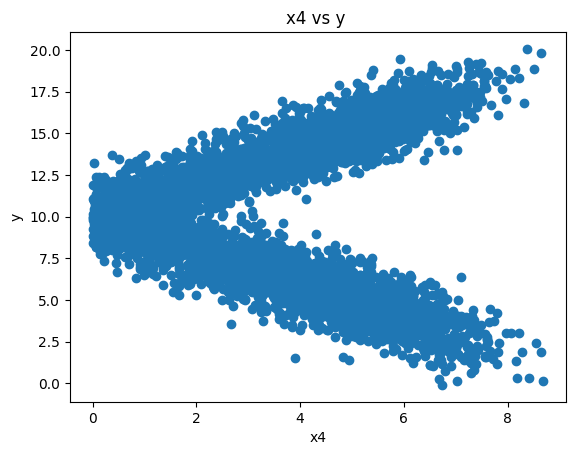

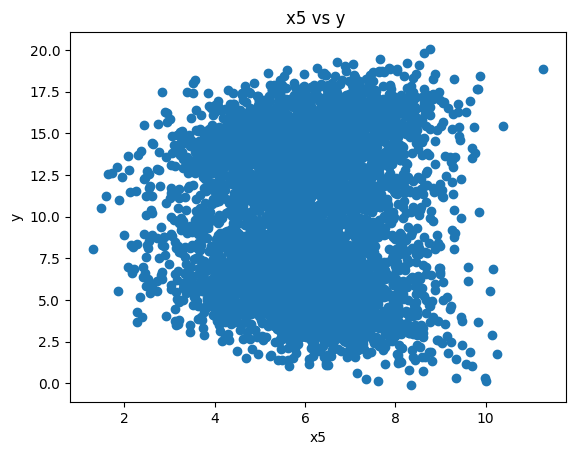

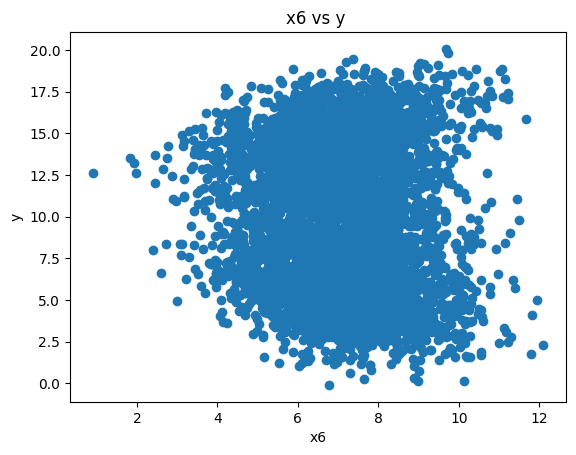

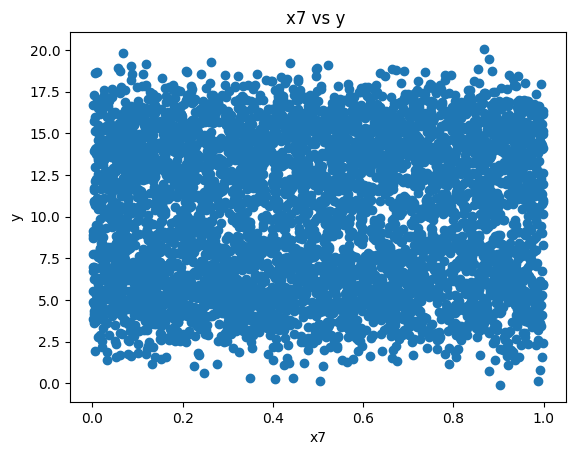

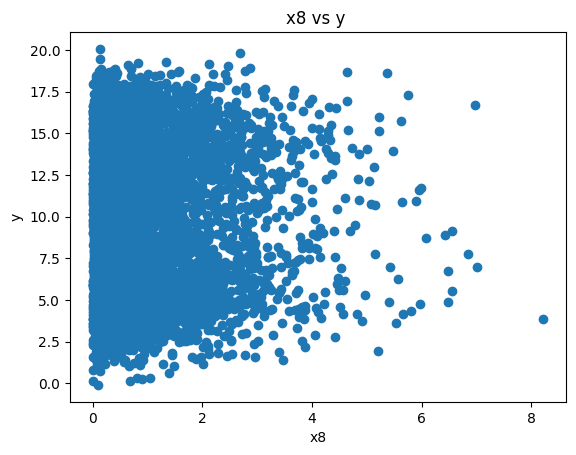

In [158]:
from matplotlib import pyplot as plt
colunas = dados.columns[:-1]
y_col = dados.columns[-1]

for idx, col in enumerate(colunas):
    plt.plot(dados[col], dados[y_col], 'o')
    plt.title(f'{col} vs {y_col} ')
    plt.xlabel(col)
    plt.ylabel(y_col)
    plt.show()

## 1.3 Histograma dos dados

In [159]:
def determina_bins(x, bins_rule = 'fd'):
    if bins_rule == 'classic':
        bins = int(len(x)**0.5)
    elif bins_rule == 'sturges':
        bins = int(np.ceil(np.log2(len(x)) + 1))
    elif bins_rule == 'scott': #ótima para distribuição normal
        bins = int((np.max(x) - np.min(x)) / (3.5 * np.std(x) * len(x)**(-1/3)))
    elif bins_rule == 'fd': #mais robusta para outliers
        bins = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))

    return bins

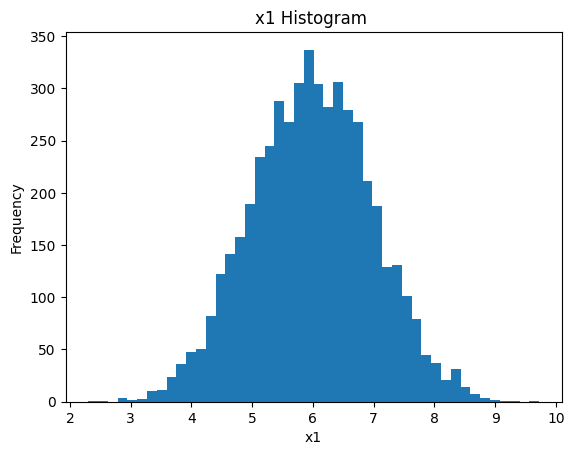

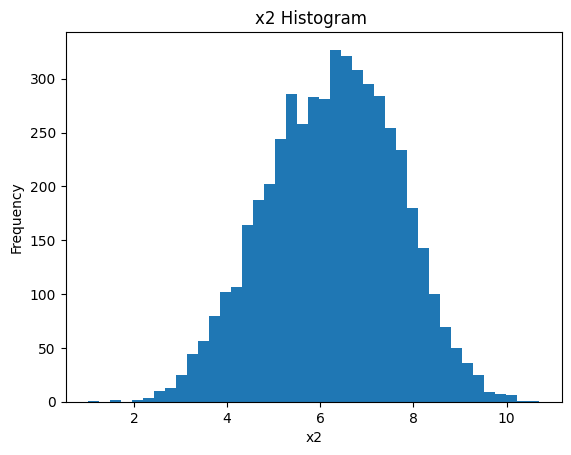

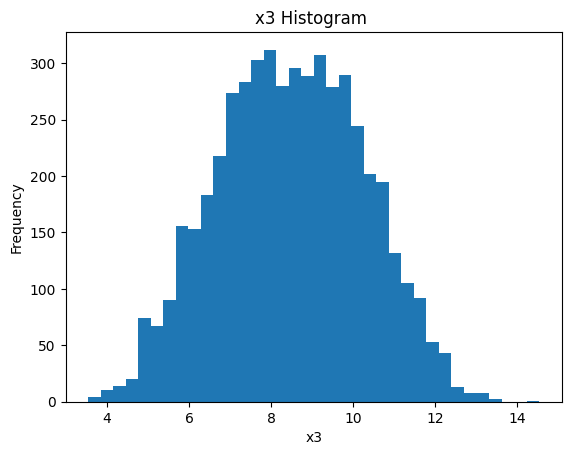

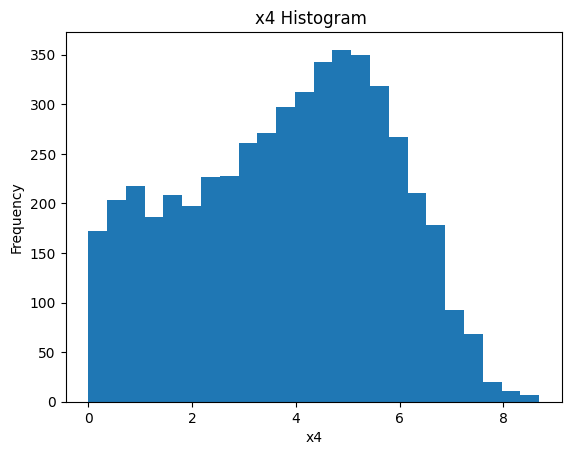

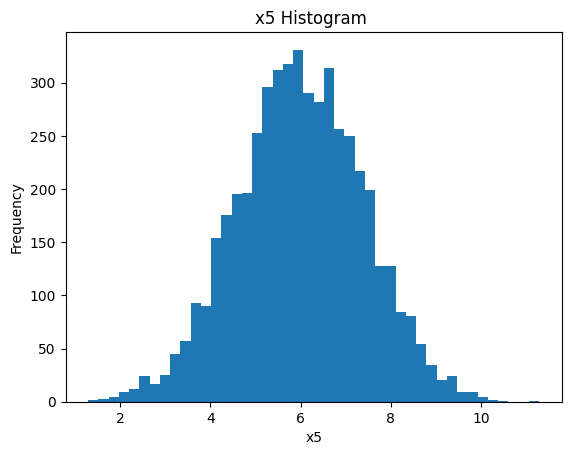

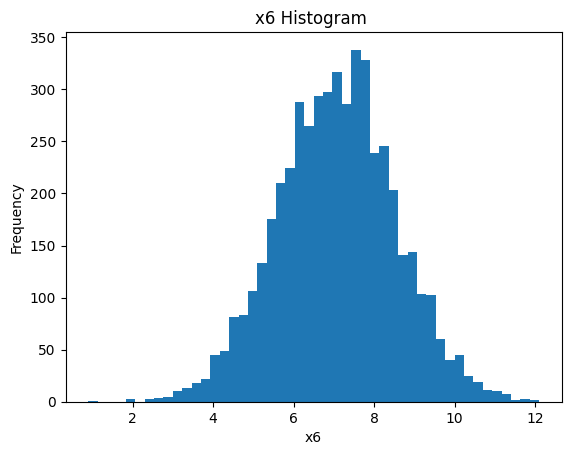

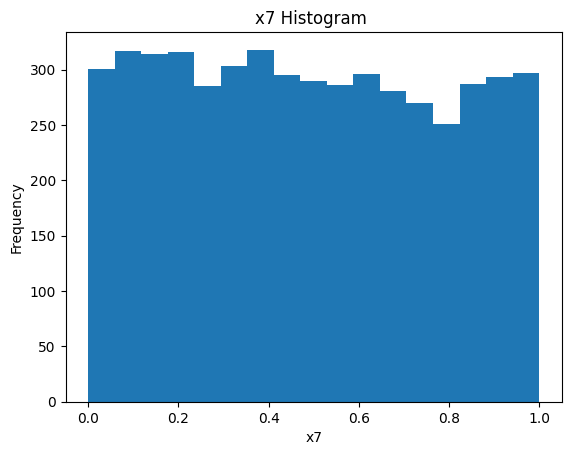

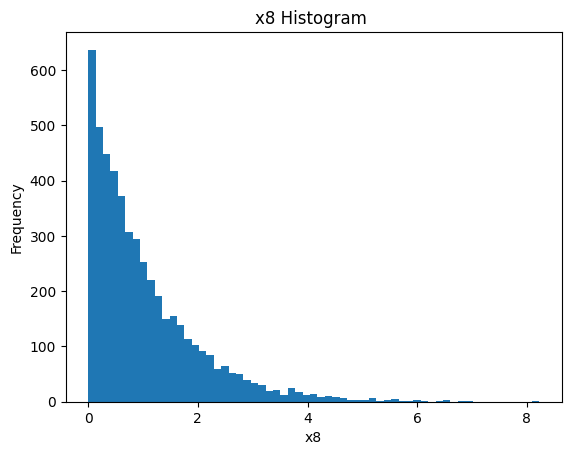

In [160]:
from matplotlib import pyplot as plt

for idx, col in enumerate(dados.columns[:-1]):
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'{col} Histogram ')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#  2. Modificações nos dados

## 2.1 Converte os dados para distribuição

In [161]:
import numpy as np
import bisect

def converte_bins(x):
    '''
    Converte a coluna x em bins discretos.
    Parâmetros:
    x: array-like, coluna a ser convertida.
    bins: int, número de bins.
    Retorna:
    array-like, coluna
    '''
    edge = np.linspace(x.min(), x.max(), determina_bins(x)+1)

    x_bins = []
    for xi in x:
      x_bins.append(bisect.bisect_left(edge, xi))
    return x_bins

In [182]:
dados_bins = pd.DataFrame()
for col in dados.columns[:-1]:
    dados_bins['b'+col] = converte_bins(dados[col])
dados_bins

,bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8
0,14,15,3,0,11,13,15,2
1,16,17,5,1,19,18,9,6
2,23,21,8,1,24,20,11,4
3,23,21,8,1,19,16,8,7
4,29,26,12,1,28,25,5,10
...,...,...,...,...,...,...,...,...
4995,26,20,27,2,25,29,5,10
4996,25,19,26,2,24,25,17,1
4997,19,15,23,2,17,31,7,7
4998,26,20,26,2,20,37,3,14


# 2.2 Transformações

In [163]:

!pip install optuna

Primeiramente determina-se o valor de alpha por meio do Optuna e depois aplica a transformação x' = x**alpha.



In [164]:
from scipy.stats import shapiro
import optuna as opt

opt.logging.set_verbosity(opt.logging.CRITICAL)

def objective(trial, col_idx):
    col = dados.columns[col_idx]
    alpha = trial.suggest_float('alpha', -1.0, 1.0)
    coluna_modificada = dados[col]
    try:
        dados_transf = coluna_modificada**alpha
        if np.any(np.isnan(dados_transf)) or np.any(np.isinf(dados_transf)):
            return -np.inf  # penaliza soluções inválidas
        stat, p = shapiro(dados_transf)
        return stat
    except Exception:
        return -np.inf

print(f'              Coluna             | Alfa')
print(f'---------------------------------|-------------')
parametro_alpha_transformacao = []
for idx in range(len(dados.columns)-1):
    study = opt.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, idx), n_trials=100, show_progress_bar=False)
    print(f'{dados.columns[idx].ljust(32)} | {study.best_params["alpha"]:.3f}')
    parametro_alpha_transformacao.append(np.float64(study.best_params["alpha"]))

              Coluna             | Alfa
---------------------------------|-------------
x1                               | 0.993
x2                               | 1.000
x3                               | 0.968
x4                               | 1.000
x5                               | 1.000
x6                               | 1.000
x7                               | 0.747
x8                               | 0.290


In [165]:
dados_transformados = pd.DataFrame()
for idx, col in enumerate(colunas):
    dados_transformados['t'+col] = np.power(dados[col], parametro_alpha_transformacao[idx])

In [166]:
dados_transformados.isna().sum()

,0
tx1,0
tx2,0
tx3,0
tx4,0
tx5,0
tx6,0
tx7,0
tx8,0


Mostrar os histogramas originais e dos dados transformados

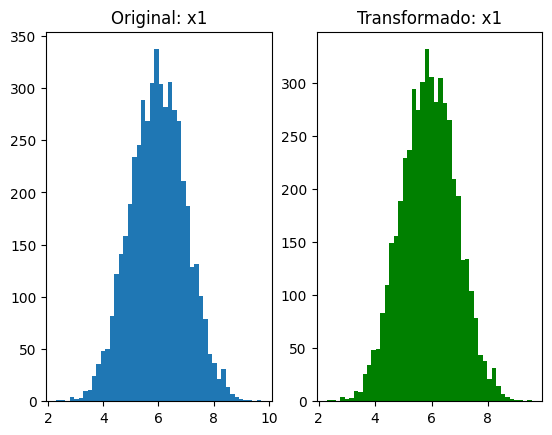

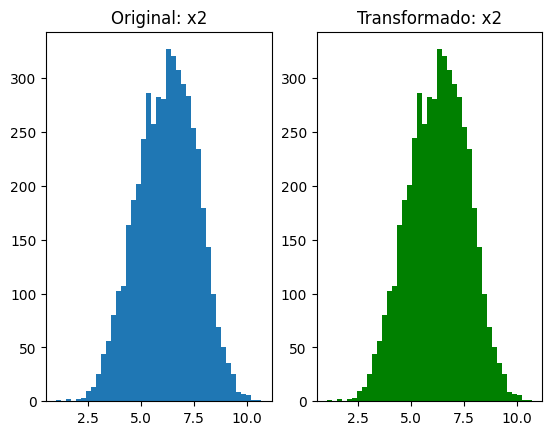

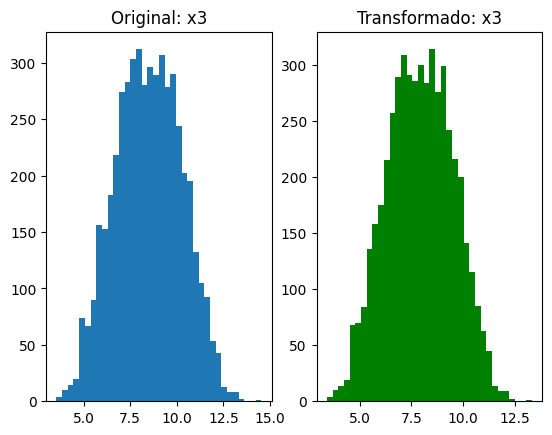

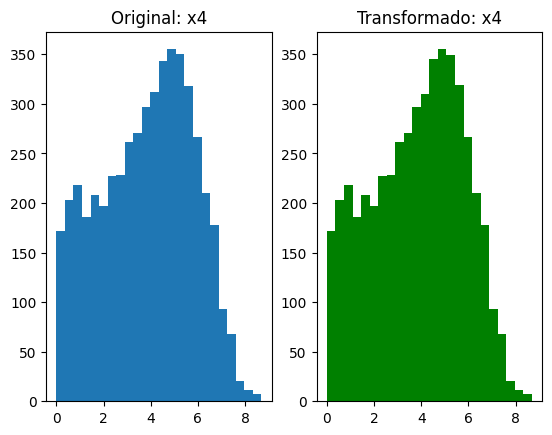

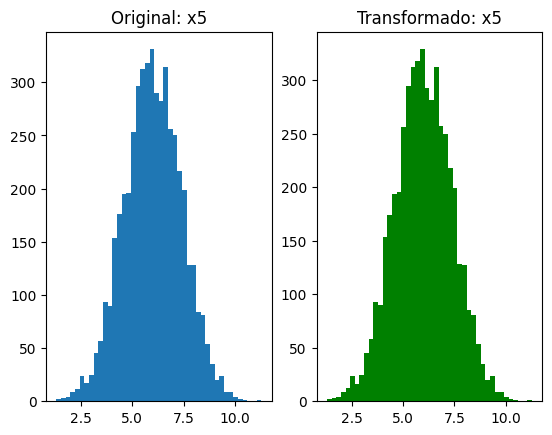

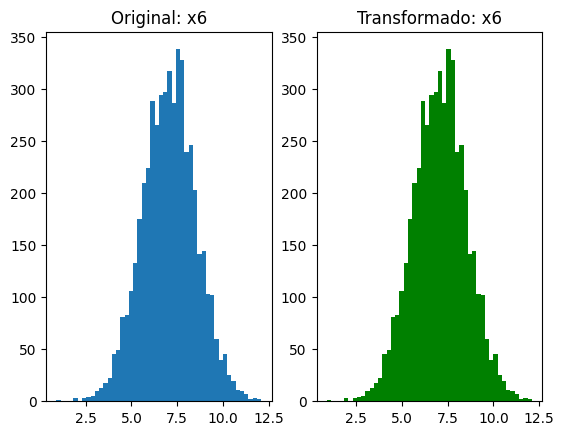

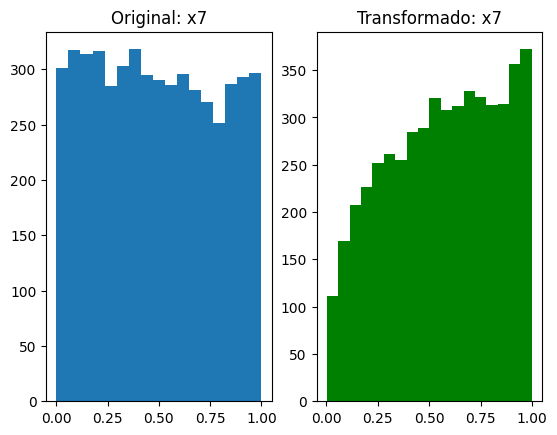

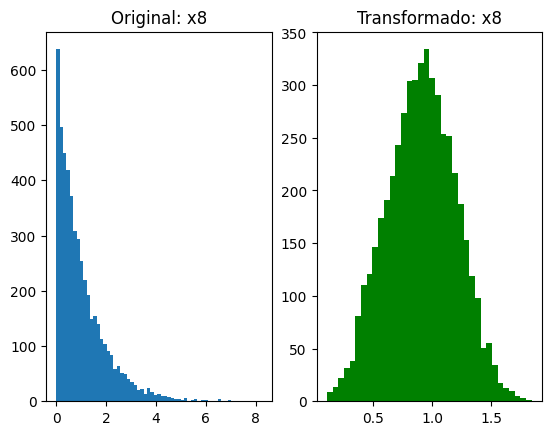

In [167]:
# Exemplo: mostrar histogramas antes e depois da transformação para cada coluna
import matplotlib.pyplot as plt

for idx in range(len(dados.columns)-1):
    col = dados.columns[idx]

    plt.subplot(1, 2, 1)
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'Original: {col}')
    plt.subplot(1, 2, 2)
    plt.hist(dados_transformados['t'+col], bins=determina_bins(dados_transformados['t'+col]), color= 'g')
    plt.title(f'Transformado: {col}')
    plt.show()

## 2.3 Cria interações entre os dados

Aqui serão criadas interações entre os dados originais (apenas entre eles), entre os dados transformados em 2.2 (apenas entre eles) e entre os dados transformado em bins em 2.1 (apenas entre eles).

As interações a serem feitas são de multiplicação e potencia (até a 3), utilizando PolynomialFeatures do Sklearn.

In [185]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
dados_inter = pd.DataFrame(poly.fit_transform(dados[dados.columns[:-1]]))
dados_inter.columns = poly.get_feature_names_out()

dados_inter

,x1,x2,x3,x4,x5,x6,x7,x8,x1^2,x1 x2,...,x6^3,x6^2 x7,x6^2 x8,x6 x7^2,x6 x7 x8,x6 x8^2,x7^3,x7^2 x8,x7 x8^2,x8^3
0,4.418979,4.418979,4.418979,0.000000,3.790175,3.851154,0.841437,0.172644,19.527373,19.527373,...,57.117949,12.479679,2.560549,2.726680,0.559453,0.114787,0.595751,0.122235,0.025080,0.005146
1,4.806399,4.809399,4.807399,0.012016,5.424897,4.890461,0.498349,0.696455,23.101470,23.115889,...,116.963225,11.918819,16.656828,1.214555,1.697369,2.372112,0.123766,0.172966,0.241724,0.337814
2,5.969800,5.975800,5.971800,0.029849,6.736295,5.470011,0.596714,0.516318,35.638506,35.674325,...,163.668348,17.854292,15.448749,1.947693,1.685277,1.458216,0.212470,0.183844,0.159074,0.137642
3,5.926910,5.935910,5.929910,0.044451,5.585835,4.524609,0.429700,0.844668,35.128267,35.181609,...,92.628206,8.796856,17.292121,0.835433,1.642224,3.228147,0.079341,0.155961,0.306576,0.602640
4,6.970652,6.982651,6.974652,0.069705,7.504256,6.702637,0.263222,1.334756,48.589984,48.673631,...,301.118265,11.825359,59.964360,0.464399,2.354889,11.941237,0.018238,0.092480,0.468950,2.377965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6.487164,5.683759,11.482164,0.511116,6.789837,7.482020,0.262661,1.336890,42.083291,36.871471,...,418.848162,14.703936,74.839963,0.516191,2.627305,13.372435,0.018121,0.092233,0.469448,2.389392
4996,6.294572,5.488636,11.290572,0.480253,6.525889,6.712077,0.969564,0.030908,39.621641,34.548614,...,302.392362,43.680797,1.392482,6.309723,0.201145,0.006412,0.911444,0.029056,0.000926,0.000030
4997,5.301585,4.493119,10.298585,0.391275,5.146483,8.045224,0.409723,0.892275,28.106801,23.820653,...,520.732222,26.519548,57.753074,1.350572,2.941215,6.405245,0.068781,0.149788,0.326203,0.710389
4998,6.342853,5.531862,11.340853,0.452309,5.727391,9.408196,0.161502,1.823239,40.231779,35.087784,...,832.758616,14.295193,161.382488,0.245392,2.770303,31.274738,0.004212,0.047555,0.536864,6.060814


In [186]:
poly = PolynomialFeatures(degree=3, include_bias=False)
dados_transformados_inter = pd.DataFrame(poly.fit_transform(dados_transformados))
dados_transformados_inter.columns = poly.get_feature_names_out()

dados_transformados_inter

,tx1,tx2,tx3,tx4,tx5,tx6,tx7,tx8,tx1^2,tx1 tx2,...,tx6^3,tx6^2 tx7,tx6^2 tx8,tx6 tx7^2,tx6 tx7 tx8,tx6 tx8^2,tx7^3,tx7^2 tx8,tx7 tx8^2,tx8^3
0,4.370827,4.418511,4.212679,0.000000,3.788268,3.851074,0.879007,0.601363,19.104130,19.312547,...,57.114409,13.036353,8.918676,2.975545,2.035686,1.392692,0.679168,0.464645,0.317882,0.217475
1,4.751081,4.808861,4.570559,0.012021,5.421434,4.890342,0.594377,0.900562,22.572771,22.847287,...,116.954691,14.214793,21.537338,1.727681,2.617670,3.966125,0.209984,0.318154,0.482047,0.730366
2,5.891668,5.975038,5.638111,0.029858,6.731444,5.469869,0.679987,0.825814,34.711750,35.202941,...,163.655563,20.344849,24.707923,2.529171,3.071567,3.730282,0.314414,0.381842,0.463730,0.563180
3,5.849651,5.935157,5.599831,0.044464,5.582208,4.524505,0.532084,0.952300,34.218415,34.718597,...,92.621779,10.892360,19.494671,1.280946,2.292581,4.103162,0.150640,0.269609,0.482534,0.863618
4,6.871563,6.981685,6.552119,0.069722,7.498547,6.702442,0.368969,1.087194,47.218377,47.975085,...,301.091930,16.575089,48.839699,0.912457,2.688622,7.922219,0.050231,0.148008,0.436118,1.285052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6.398338,5.683055,10.614925,0.511148,6.784928,7.481789,0.368381,1.087697,40.938733,36.362108,...,418.809413,20.620930,60.886189,1.015313,2.997855,8.851587,0.049991,0.147605,0.435826,1.286837
4996,6.209764,5.487970,10.443457,0.480285,6.521269,6.711881,0.977176,0.365460,38.561169,34.078997,...,302.365895,44.021164,16.463736,6.408999,2.396940,0.896446,0.933080,0.348968,0.130513,0.048811
4997,5.236780,4.492638,9.554125,0.391309,5.143301,8.044967,0.513494,0.967538,27.423867,23.526959,...,520.682309,33.234120,62.620530,2.121268,3.996944,7.531139,0.135396,0.255117,0.480698,0.905742
4998,6.257041,5.531188,10.488465,0.452342,5.723618,9.407873,0.256165,1.189928,39.150562,34.608868,...,832.672805,22.672691,105.318231,0.617350,2.867690,13.320874,0.016810,0.078084,0.362712,1.684853


In [187]:
poly = PolynomialFeatures(degree=3, include_bias=False)
dados_bins_inter = pd.DataFrame(poly.fit_transform(dados_bins))
dados_bins_inter.columns = poly.get_feature_names_out()

dados_bins_inter

,bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8,bx1^2,bx1 bx2,...,bx6^3,bx6^2 bx7,bx6^2 bx8,bx6 bx7^2,bx6 bx7 bx8,bx6 bx8^2,bx7^3,bx7^2 bx8,bx7 bx8^2,bx8^3
0,14.0,15.0,3.0,0.0,11.0,13.0,15.0,2.0,196.0,210.0,...,2197.0,2535.0,338.0,2925.0,390.0,52.0,3375.0,450.0,60.0,8.0
1,16.0,17.0,5.0,1.0,19.0,18.0,9.0,6.0,256.0,272.0,...,5832.0,2916.0,1944.0,1458.0,972.0,648.0,729.0,486.0,324.0,216.0
2,23.0,21.0,8.0,1.0,24.0,20.0,11.0,4.0,529.0,483.0,...,8000.0,4400.0,1600.0,2420.0,880.0,320.0,1331.0,484.0,176.0,64.0
3,23.0,21.0,8.0,1.0,19.0,16.0,8.0,7.0,529.0,483.0,...,4096.0,2048.0,1792.0,1024.0,896.0,784.0,512.0,448.0,392.0,343.0
4,29.0,26.0,12.0,1.0,28.0,25.0,5.0,10.0,841.0,754.0,...,15625.0,3125.0,6250.0,625.0,1250.0,2500.0,125.0,250.0,500.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,26.0,20.0,27.0,2.0,25.0,29.0,5.0,10.0,676.0,520.0,...,24389.0,4205.0,8410.0,725.0,1450.0,2900.0,125.0,250.0,500.0,1000.0
4996,25.0,19.0,26.0,2.0,24.0,25.0,17.0,1.0,625.0,475.0,...,15625.0,10625.0,625.0,7225.0,425.0,25.0,4913.0,289.0,17.0,1.0
4997,19.0,15.0,23.0,2.0,17.0,31.0,7.0,7.0,361.0,285.0,...,29791.0,6727.0,6727.0,1519.0,1519.0,1519.0,343.0,343.0,343.0,343.0
4998,26.0,20.0,26.0,2.0,20.0,37.0,3.0,14.0,676.0,520.0,...,50653.0,4107.0,19166.0,333.0,1554.0,7252.0,27.0,126.0,588.0,2744.0


Também serão feitas as interações de soma entre 2 atributos e de max(a,b) para os mesmos conjuntos de dados, entre eles, como descrito acima. Este já são adicionados ao dataframe das interações polinomiais.

In [188]:
len_dados = len(dados.columns)-1
for idx1 in range(len_dados):
  for idx2 in range(idx1+1, len_dados):
    col1 = dados.columns[idx1]
    col2 = dados.columns[idx2]
    dados_inter[f'{col1}+{col2}'] = dados[col1] + dados[col2]
    dados_inter[f'max({col1},{col2})'] = np.maximum(dados[col1], dados[col2])
dados_inter

,x1,x2,x3,x4,x5,x6,x7,x8,x1^2,x1 x2,...,x5+x7,"max(x5,x7)",x5+x8,"max(x5,x8)",x6+x7,"max(x6,x7)",x6+x8,"max(x6,x8)",x7+x8,"max(x7,x8)"
0,4.418979,4.418979,4.418979,0.000000,3.790175,3.851154,0.841437,0.172644,19.527373,19.527373,...,4.631612,3.790175,3.962818,3.790175,4.692591,3.851154,4.023798,3.851154,1.014081,0.841437
1,4.806399,4.809399,4.807399,0.012016,5.424897,4.890461,0.498349,0.696455,23.101470,23.115889,...,5.923246,5.424897,6.121352,5.424897,5.388810,4.890461,5.586915,4.890461,1.194804,0.696455
2,5.969800,5.975800,5.971800,0.029849,6.736295,5.470011,0.596714,0.516318,35.638506,35.674325,...,7.333008,6.736295,7.252612,6.736295,6.066725,5.470011,5.986329,5.470011,1.113031,0.596714
3,5.926910,5.935910,5.929910,0.044451,5.585835,4.524609,0.429700,0.844668,35.128267,35.181609,...,6.015535,5.585835,6.430503,5.585835,4.954309,4.524609,5.369277,4.524609,1.274368,0.844668
4,6.970652,6.982651,6.974652,0.069705,7.504256,6.702637,0.263222,1.334756,48.589984,48.673631,...,7.767478,7.504256,8.839011,7.504256,6.965859,6.702637,8.037393,6.702637,1.597978,1.334756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6.487164,5.683759,11.482164,0.511116,6.789837,7.482020,0.262661,1.336890,42.083291,36.871471,...,7.052498,6.789837,8.126728,6.789837,7.744681,7.482020,8.818911,7.482020,1.599552,1.336890
4996,6.294572,5.488636,11.290572,0.480253,6.525889,6.712077,0.969564,0.030908,39.621641,34.548614,...,7.495454,6.525889,6.556798,6.525889,7.681642,6.712077,6.742985,6.712077,1.000473,0.969564
4997,5.301585,4.493119,10.298585,0.391275,5.146483,8.045224,0.409723,0.892275,28.106801,23.820653,...,5.556206,5.146483,6.038759,5.146483,8.454947,8.045224,8.937499,8.045224,1.301998,0.892275
4998,6.342853,5.531862,11.340853,0.452309,5.727391,9.408196,0.161502,1.823239,40.231779,35.087784,...,5.888893,5.727391,7.550630,5.727391,9.569698,9.408196,11.231436,9.408196,1.984741,1.823239


In [189]:
len_dados_transformados = len(dados_transformados.columns)
for idx1 in range(len_dados_transformados):
  for idx2 in range(idx1+1, len_dados_transformados):
    col1 = dados_transformados.columns[idx1]
    col2 = dados_transformados.columns[idx2]
    dados_transformados_inter[f'{col1}+{col2}'] = dados_transformados[col1] + dados_transformados[col2]
    dados_transformados_inter[f'max({col1},{col2})'] = np.maximum(dados_transformados[col1], dados_transformados[col2])
dados_transformados_inter

,tx1,tx2,tx3,tx4,tx5,tx6,tx7,tx8,tx1^2,tx1 tx2,...,tx5+tx7,"max(tx5,tx7)",tx5+tx8,"max(tx5,tx8)",tx6+tx7,"max(tx6,tx7)",tx6+tx8,"max(tx6,tx8)",tx7+tx8,"max(tx7,tx8)"
0,4.370827,4.418511,4.212679,0.000000,3.788268,3.851074,0.879007,0.601363,19.104130,19.312547,...,4.667275,3.788268,4.389631,3.788268,4.730081,3.851074,4.452437,3.851074,1.480370,0.879007
1,4.751081,4.808861,4.570559,0.012021,5.421434,4.890342,0.594377,0.900562,22.572771,22.847287,...,6.015812,5.421434,6.321996,5.421434,5.484719,4.890342,5.790904,4.890342,1.494939,0.900562
2,5.891668,5.975038,5.638111,0.029858,6.731444,5.469869,0.679987,0.825814,34.711750,35.202941,...,7.411431,6.731444,7.557259,6.731444,6.149856,5.469869,6.295683,5.469869,1.505801,0.825814
3,5.849651,5.935157,5.599831,0.044464,5.582208,4.524505,0.532084,0.952300,34.218415,34.718597,...,6.114291,5.582208,6.534508,5.582208,5.056588,4.524505,5.476805,4.524505,1.484384,0.952300
4,6.871563,6.981685,6.552119,0.069722,7.498547,6.702442,0.368969,1.087194,47.218377,47.975085,...,7.867516,7.498547,8.585740,7.498547,7.071411,6.702442,7.789635,6.702442,1.456163,1.087194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6.398338,5.683055,10.614925,0.511148,6.784928,7.481789,0.368381,1.087697,40.938733,36.362108,...,7.153309,6.784928,7.872625,6.784928,7.850170,7.481789,8.569486,7.481789,1.456078,1.087697
4996,6.209764,5.487970,10.443457,0.480285,6.521269,6.711881,0.977176,0.365460,38.561169,34.078997,...,7.498445,6.521269,6.886729,6.521269,7.689058,6.711881,7.077341,6.711881,1.342636,0.977176
4997,5.236780,4.492638,9.554125,0.391309,5.143301,8.044967,0.513494,0.967538,27.423867,23.526959,...,5.656795,5.143301,6.110839,5.143301,8.558461,8.044967,9.012505,8.044967,1.481033,0.967538
4998,6.257041,5.531188,10.488465,0.452342,5.723618,9.407873,0.256165,1.189928,39.150562,34.608868,...,5.979783,5.723618,6.913546,5.723618,9.664039,9.407873,10.597801,9.407873,1.446093,1.189928


In [190]:
len_dados_bins = len(dados_bins.columns)
for idx1 in range(len_dados_bins):
  for idx2 in range(idx1+1, len_dados_bins):
    col1 = dados_bins.columns[idx1]
    col2 = dados_bins.columns[idx2]
    dados_bins_inter[f'{col1}+{col2}'] = dados_bins[col1] + dados_bins[col2]
    dados_bins_inter[f'max({col1},{col2})'] = np.maximum(dados_bins[col1], dados_bins[col2])
dados_bins_inter

,bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8,bx1^2,bx1 bx2,...,bx5+bx7,"max(bx5,bx7)",bx5+bx8,"max(bx5,bx8)",bx6+bx7,"max(bx6,bx7)",bx6+bx8,"max(bx6,bx8)",bx7+bx8,"max(bx7,bx8)"
0,14.0,15.0,3.0,0.0,11.0,13.0,15.0,2.0,196.0,210.0,...,26,15,13,11,28,15,15,13,17,15
1,16.0,17.0,5.0,1.0,19.0,18.0,9.0,6.0,256.0,272.0,...,28,19,25,19,27,18,24,18,15,9
2,23.0,21.0,8.0,1.0,24.0,20.0,11.0,4.0,529.0,483.0,...,35,24,28,24,31,20,24,20,15,11
3,23.0,21.0,8.0,1.0,19.0,16.0,8.0,7.0,529.0,483.0,...,27,19,26,19,24,16,23,16,15,8
4,29.0,26.0,12.0,1.0,28.0,25.0,5.0,10.0,841.0,754.0,...,33,28,38,28,30,25,35,25,15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,26.0,20.0,27.0,2.0,25.0,29.0,5.0,10.0,676.0,520.0,...,30,25,35,25,34,29,39,29,15,10
4996,25.0,19.0,26.0,2.0,24.0,25.0,17.0,1.0,625.0,475.0,...,41,24,25,24,42,25,26,25,18,17
4997,19.0,15.0,23.0,2.0,17.0,31.0,7.0,7.0,361.0,285.0,...,24,17,24,17,38,31,38,31,14,7
4998,26.0,20.0,26.0,2.0,20.0,37.0,3.0,14.0,676.0,520.0,...,23,20,34,20,40,37,51,37,17,14


# 3. Cálculo das correlações entre os dados de entrada e a saída



## 3.1 Cálculo da *Mutual Information*

Calculo da *Mutual Information* por meio do hitograma. A forma de definir o número de bins pode ser escolhido entre os métodos Classico, Struges, Scoot e Freedman-Diaconis.

In [191]:
def calc_mi(x, y, bins_rule='classic'):
    '''Calcula a Mutual Information entre duas variáveis x e y usando histogramas.
    Parâmetros:
    x: array-like, primeira variável.
    y: array-like, segunda variável.
    bins_rule: str, regra para determinar o número de bins. Opções: 'classic', 'sturges', 'scott', 'fd'.
    Retorna:
    mi: float, valor da Mutual Information.
    '''

    bins_x = determina_bins(x, bins_rule)
    bins_y = determina_bins(y, bins_rule)

    hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[bins_x, bins_y])

    hist2d_norm = hist2d / np.sum(hist2d)

    hist_x = np.sum(hist2d_norm, axis=1)
    hist_y = np.sum(hist2d_norm, axis=0)

    entropia_x = -sum(hist_x[hist_x > 0] * np.log(hist_x[hist_x > 0]))
    entropia_y = -sum(hist_y[hist_y > 0] * np.log(hist_y[hist_y > 0]))

    entropia_conjunta = -sum(hist2d_norm[hist2d_norm > 0] * np.log(hist2d_norm[hist2d_norm > 0]))

    mi = entropia_x + entropia_y - entropia_conjunta

    return mi

**Dúvida:** Na minha cabeça faz mais sentido colocar os os métodos de determinação da bin como entrada, pode ser assim?

Testes da Mutual Information utilizando diferentes formas de calcular os bins, apenas para os dados originais.

In [198]:
bins_rule = ['classic', 'sturges', 'scott', 'fd']

print(f'  Teste do Mutual Information com os dados originais\n')
print(f'  Dado   | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print(f'---------|---------|---------|---------|--------')
for idx, col in enumerate(dados.columns[:-1]):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dados[col], dados[y_col], bins_rule=br))
    print(f'{col.center(9)}|  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')


  Teste do Mutual Information com os dados originais

  Dado   | classic | sturges |  scott  |  fd
---------|---------|---------|---------|--------
    x1   |  0.376  |  0.086  |  0.134  |  0.147
    x2   |  0.397  |  0.104  |  0.148  |  0.154
    x3   |  0.461  |  0.152  |  0.198  |  0.201
    x4   |  0.942  |  0.638  |  0.700  |  0.701
    x5   |  0.366  |  0.045  |  0.094  |  0.107
    x6   |  0.343  |  0.043  |  0.094  |  0.112
    x7   |  0.464  |  0.017  |  0.028  |  0.030
    x8   |  0.247  |  0.014  |  0.054  |  0.076


Mutual Information, usando Freedman–Diaconis, aplicada aos dados originais, aos dados em bins e aos dados transformados, todos com as suas interações.

In [208]:
print(f'    Dado    | Original | Transformado |    Bins')
print(f'------------|----------|--------------|--------------')
col_transf = dados_transformados_inter.columns
col_bins = dados_bins_inter.columns
for idx, col in enumerate(dados_inter.columns):
    mi_dados = calc_mi(dados_inter[col], dados['y'], bins_rule='fd')
    mi_transform = calc_mi(dados_transformados_inter[col_transf[idx]], dados['y'], bins_rule='fd')
    mi_bins = calc_mi(dados_bins_inter[col_bins[idx]], dados['y'], bins_rule='fd')

    print(f'{col.center(12)}|   {mi_dados:.3f}  |     {mi_transform:.3f}    |   {mi_bins:.3f}  ')

    Dado    | Original | Transformado |    Bins
------------|----------|--------------|--------------
     x1     |   0.147  |     0.146    |   0.142  
     x2     |   0.154  |     0.154    |   0.154  
     x3     |   0.201  |     0.199    |   0.199  
     x4     |   0.701  |     0.701    |   0.701  
     x5     |   0.107  |     0.106    |   0.107  
     x6     |   0.112  |     0.112    |   0.112  
     x7     |   0.030  |     0.030    |   0.031  
     x8     |   0.076  |     0.064    |   0.076  
    x1^2    |   0.144  |     0.148    |   0.135  
   x1 x2    |   0.166  |     0.163    |   0.169  
   x1 x3    |   0.177  |     0.170    |   0.184  
   x1 x4    |   0.649  |     0.650    |   0.574  
   x1 x5    |   0.131  |     0.132    |   0.126  
   x1 x6    |   0.130  |     0.130    |   0.131  
   x1 x7    |   0.052  |     0.061    |   0.069  
   x1 x8    |   0.092  |     0.082    |   0.098  
    x2^2    |   0.156  |     0.157    |   0.145  
   x2 x3    |   0.174  |     0.177    |   0.188 

Os 2 dados de maior correlação com a saída, considerando o Mutual Information, são *Study_Hours_Per_Day* e *GPA*.

## 3.2 Hilbert-Schmidt Independence Criterion (HSIC)

In [209]:
from sklearn.metrics.pairwise import rbf_kernel

def calc_hsic(x, y, sigma_x = None, sigma_y = None):

    x = np.asarray(x)
    y = np.asarray(y)

    len_x = len(x)

    H = np.eye(len_x) - np.ones((len_x, len_x))/len_x

    if sigma_x is None:
        sigma_x = np.median(np.abs(x[:, None] - x[None, :]))

    if sigma_y is None:
        sigma_y = np.median(np.abs(y[:, None] - y[None, :]))

    K = rbf_kernel(x.reshape(-1, 1), gamma=1/(2*sigma_x**2))
    L = rbf_kernel(y.reshape(-1, 1), gamma=1/(2*sigma_y**2))

    return np.trace(H @ K @ H @ L) / (len_x - 1)**2

**Dúvida:** Na minha cabeça faz mais sentido calcular o sigma para os dados inseridos, pode ser assim?

HSIC aplicada aos dados originais, aos dados em bins e aos dados transformados.

In [ ]:
colunas = dados.columns[:-1]
col_transf = dados_transformados_inter.columns
col_bins = dados_bins_inter.columns

print(f'    Dado    | Original | Transformado |    Bins')
print(f'------------|----------|--------------|--------------')
for idx, col in enumerate(dados_inter.columns):
  hsic_dados = calc_hsic(dados_inter[col], dados['y'])
  hsic_transform = calc_hsic(dados_transformados_inter[col_transf[idx]], dados['y'])
  hsic_bins = calc_hsic(dados_bins_inter[col_bins[idx]], dados['y'])

  print(f'{col.ljust(12)}|  {hsic_dados:.5f} |    {hsic_transform:.5f}   |   {hsic_bins:.5f}  ')


    Dado    | Original | Transformado |    Bins
------------|----------|--------------|--------------
x1          |  0.00168 |    0.00168   |   0.00167  
x2          |  0.00409 |    0.00409   |   0.00406  
x3          |  0.00895 |    0.00895   |   0.00890  
x4          |  0.02085 |    0.02085   |   0.02102  


Os 2 dados de maior correlação com a saída, considerando o HSIC, são *Study_Hours_Per_Day* e *GPA*.

## Considerações

Considerando os resultados apresentados pela avaliação de correlação do Mutual Information e do HSIC concluimos que as entradas **Study_Hours_Per_Day** e **GPA** são as que tem maior correlação por ambos os métodos.

In [ ]:
col_top = ["Study_Hours_Per_Day", "GPA"]

# 4. Avaliação com xgBoost + SHAP

## 4.1. Teste Inicial

Testa os dados originais, separados por bins e transformados com todos os atributos. Em seguida testa os mesmos, mas apenas com os melhores atributos definidos na list *col_top*.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import xgboost

def evaluate_model_xgBoost(X, y, id):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = XGBRegressor()
  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f'{id.ljust(10)}|  {mse_train:.10f}  |  {mse:.10f}')

In [ ]:
print(f'  Dado    |     Train      |  Test ')
print(f'----------|----------------|-------')
evaluate_model_xgBoost(dados[dados.columns[:-1]], dados[y_col], 'Dados')
evaluate_model_xgBoost(dados_bins[dados_bins.columns[:-1]], dados[y_col], 'Bins')
evaluate_model_xgBoost(dados_transformados[dados_transformados.columns[:-1]], dados[y_col], 'Transform')
print(f'TOP Atribu|----------------|-------')
evaluate_model_xgBoost(dados[col_top], dados[y_col], 'Dados')
evaluate_model_xgBoost(dados_bins[col_top], dados[y_col], 'Bins')
evaluate_model_xgBoost(dados_transformados[col_top], dados[y_col], 'Transform')


  Dado    |     Train      |  Test 
----------|----------------|-------
Dados     |  0.0000000010  |  0.0000000011
Bins      |  0.0023895234  |  0.0671193153
Transform |  0.0000000010  |  0.0000000011
TOP Atribu|----------------|-------
Dados     |  0.0550858788  |  0.2480267733
Bins      |  0.1872875243  |  0.1991864443
Transform |  0.0550858788  |  0.2480267733


## 4.2. Avaliação dos Atibutos Originais

### 4.2.1. Com *plot_importance*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

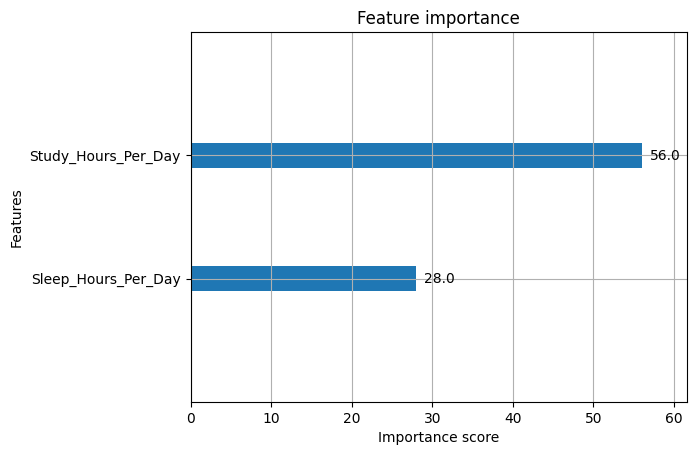

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dados[dados.columns[:-1]], dados[y_col], test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

xgboost.plot_importance(model)

### 4.2.2. Com SHAP

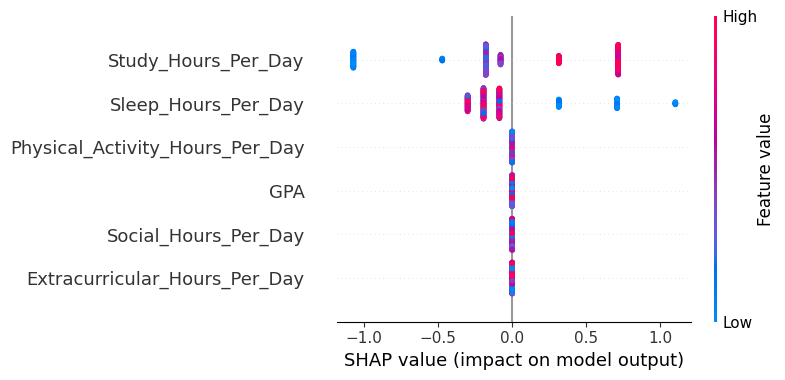

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 4.2.3. Teste Modelo


In [ ]:
dados.columns

Index(['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
       'Physical_Activity_Hours_Per_Day', 'GPA', 'Stress_Level'],
      dtype='object')

In [ ]:
col_feature = ['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day']
col_shap = ['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day']

print(f'  Dado    |     Train      |  Test ')
print(f'----------|----------------|-------')
evaluate_model_xgBoost(dados[dados.columns[:-1]], dados[y_col], 'Dados')
evaluate_model_xgBoost(dados[col_feature], dados[y_col], 'Feature')
evaluate_model_xgBoost(dados[col_shap], dados[y_col], 'SHAP')

  Dado    |     Train      |  Test 
----------|----------------|-------
Dados     |  0.0000000010  |  0.0000000011
Feature   |  0.0000000010  |  0.0000000011
SHAP      |  0.0000000010  |  0.0000000011


## 4.3. Avaliação dos Atributos em Bins

### 4.3.1. Com *plot_importance*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

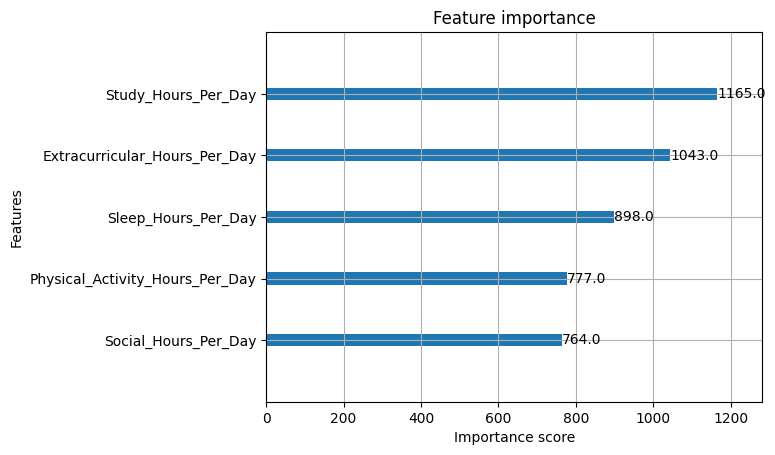

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dados_bins[dados_bins.columns[:-1]], dados[y_col], test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

xgboost.plot_importance(model)

### 4.3.2. Com SHAP

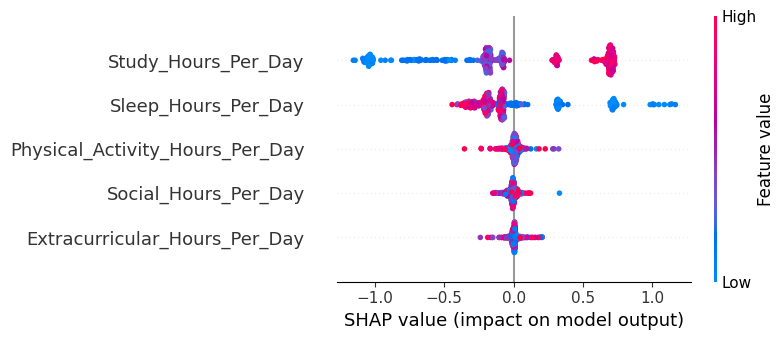

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 4.3.3. Teste Modelo

In [ ]:
col_feature = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day']
col_shap = ['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day']

print(f'  Dado    |     Train      |  Test ')
print(f'----------|----------------|-------')
evaluate_model_xgBoost(dados_bins[dados_bins.columns[:-1]], dados[y_col], 'Dados')
evaluate_model_xgBoost(dados_bins[col_feature], dados[y_col], 'Feature')
evaluate_model_xgBoost(dados_bins[col_shap], dados[y_col], 'SHAP')

  Dado    |     Train      |  Test 
----------|----------------|-------
Dados     |  0.0023895234  |  0.0671193153
Feature   |  0.1870341897  |  0.2069972605
SHAP      |  0.0319083109  |  0.0431212522


## 4.4. Avaliação dos Atributos Transformados

### 4.4.1. Com *plot_importance*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

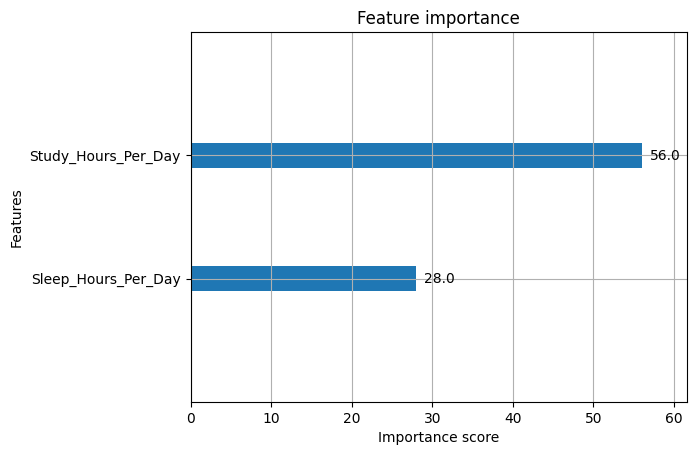

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dados_transformados[dados_transformados.columns[:-1]], dados[y_col], test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

xgboost.plot_importance(model)

### 4.4.2. Com SHAP

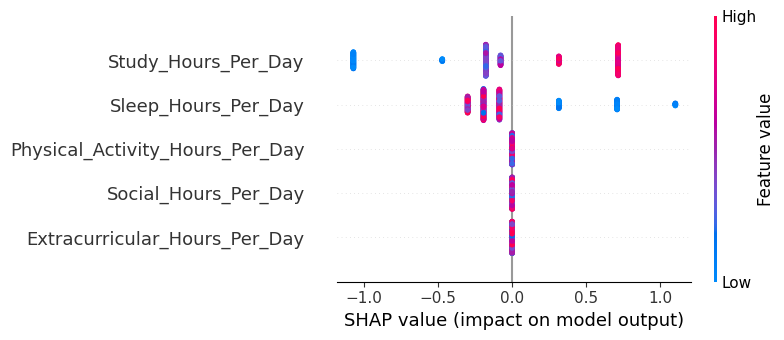

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 4.4.3. Teste Modelo



In [ ]:
col_feature = ['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day']
col_shap = ['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day']

print(f'  Dado    |     Train      |  Test ')
print(f'----------|----------------|-------')
evaluate_model_xgBoost(dados_transformados[dados_transformados.columns[:-1]], dados[y_col], 'Dados')
evaluate_model_xgBoost(dados_transformados[col_feature], dados[y_col], 'Feature')
evaluate_model_xgBoost(dados_transformados[col_shap], dados[y_col], 'SHAP')

  Dado    |     Train      |  Test 
----------|----------------|-------
Dados     |  0.0000000010  |  0.0000000011
Feature   |  0.0000000010  |  0.0000000011
SHAP      |  0.0000000010  |  0.0000000011
